In [1]:
import numpy as np
import matplotlib.pyplot as plt
import nengo
import gym
from gym import wrappers
from datetime import datetime


In [2]:
def plot_running_avg(total_rewards):
    N = len(total_rewards)
    running_avg = np.empty(N)
    for t in range(N):
        running_avg[t] = total_rewards[max(0, t-100):(t+1)].mean()
    plt.plot(running_avg)
    plt.title("Running Average of rewards")
    plt.xlabel("Simulation time")
    plt.ylabel("Score")
    plt.show()

In [3]:



class EnvironmentInterface(object):
    
    def __init__(self, env, step_size =5):
        self.env = env
        self.n_actions = env.action_space.n
        self.state_dim = env.observation_space.shape[0]
        self.t=0
        self.stepsize = step_size
        self.output = np.zeros(self.n_actions)
        self.state = env.reset()
        self.reward= 0
        self.current_action = 0
        self.reward_arr = []
        self.total_reward = 0

    def take_action(self,action):
        self.state,self.reward,self.done,_= self.env.step(action)
        self.total_reward += self.reward
        if self.done:
            self.reward = -2
            self.total_reward += self.reward
            self.reward_arr.append(self.total_reward)
            self.state = self.env.reset()
            self.total_reward = 0

    def get_reward(self,t):
        return self.reward
    
    def sensor(self,t):
        return self.state

    
    def step(self,t,x):
        if int(t*1000)%self.stepsize == 0:
            self.current_action = np.argmax(x) #np.argmax(self.output)#
            self.take_action(self.current_action)
    
    def calculate_Q(self,t,x):

        if int(t*1000) % self.stepsize == 1:
            qmax = x[np.argmax(x)]
            self.output = x
            self.output[self.current_action] = 0.9*qmax + self.reward
            
        return self.output
    
        

In [4]:
env_CartPole = gym.make('CartPole-v0').env

env_iface=EnvironmentInterface(env_CartPole)

state_dimensions=env_iface.state_dim
n_actions = env_iface.n_actions



In [5]:
tau = 0.01

fast_tau = 0
slow_tau = 0.01
n_action = 2 

model=nengo.Network()

with model:
    
    sensor = nengo.Node(env_iface.sensor)
    reward = nengo.Node(env_iface.get_reward)
    
    sensor_net = nengo.Ensemble(n_neurons=1000, dimensions=env_iface.state_dim, radius=10)
    
    nengo.Connection(sensor, sensor_net)
    
    action_net = nengo.Ensemble(n_neurons=1000, dimensions=env_iface.n_actions, radius=10)
    
    learning_conn=nengo.Connection(sensor_net, action_net,
                                   function=lambda x:[0,0],
                                   learning_rule_type=nengo.PES(1e-3, pre_synapse=nengo.Lowpass(slow_tau)),
                                   synapse=nengo.Lowpass(tau))
   
    q_node = nengo.Node(env_iface.calculate_Q,size_in=2,size_out=2)
    
    step_node = nengo.Node(env_iface.step ,size_in=2)
    
    nengo.Connection(action_net,step_node,synapse=fast_tau)
    
    nengo.Connection(action_net,q_node,synapse=tau)
    
    
    nengo.Connection(q_node,learning_conn.learning_rule,transform =-1,synapse=fast_tau) ##0.9*Q(s',a')+r
    
    nengo.Connection(action_net,learning_conn.learning_rule,transform =1,synapse=slow_tau)#Q(s,a)




In [6]:
from nengo_gui.ipython import IPythonViz
IPythonViz(model,'agent_model.py.cfg')

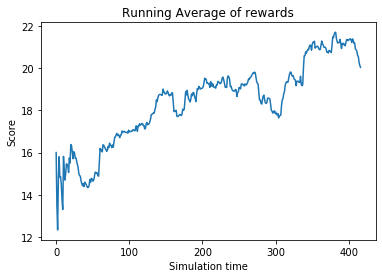

In [9]:
plot_running_avg(np.array(env_iface.reward_arr))


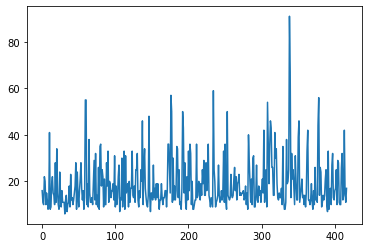

In [10]:
plt.plot(env_iface.reward_arr)